# It's not finished, I just wanted to see how much weight is given to data story assignment

In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import chart_studio as cs
import dtale

pd.options.display.float_format = '{:.4f}'.format #set it to convert scientific noations such as 4.225108e+11 to 422510842796.00
pd.set_option('display.max_columns', 100) #  display all the columns
pd.set_option('display.max_rows', 100) # display all the rows
np.set_printoptions(suppress=True,formatter={'float_kind':'{:f}'.format})

%matplotlib inline

In [ ]:
# importing the data

df = pd.read_csv('Data/loan.csv')
original_df = df.copy()
#df.drop('Unnamed: 0',axis='columns',inplace=True)
df.dropna(axis=1,how='any',thresh=int(0.3*len(df)),inplace=True)

In [8]:
df.fillna(df.median(),inplace=True)

In [9]:
df = df.rename(columns={"loan_amnt": "loan_amount", "funded_amnt": "funded_amount", "funded_amnt_inv": "investor_funds",
                       "int_rate": "interest_rate", "annual_inc": "annual_income"})

In [ ]:
df.head()

In [11]:
purpose_df=pd.DataFrame(df['purpose'].value_counts(normalize=True)*100)
purpose_df.reset_index(inplace=True)

In [12]:
df['year_issued'] = pd.to_datetime(df['issue_d']).dt.year

by_year = df.groupby('year_issued').count()[['loan_amount']]

# Overview

** This notebook attempt to achieve 2 goals:
1 - Highlight general tendencies of the company as such.
2 - Highlight the relationships between key features and the status of the loan.

** Lending club is a peer-to-peer lending platform headquatered in San-Francisco. It offers loans to the borrowers and investment opportunities to the peers willing to invest in a loan. More at: https://en.wikipedia.org/wiki/LendingClub

** The dataset itself can be found here: https://www.kaggle.com/wendykan/lending-club-loan-data 

* The absolute majority of the loans is issued for debt-consolidation(56%). The next most common category is credit card (23%)

* The average size of a loan is USD 15000 while USD 40000 is the largest one recorded.

* The interest rate varies between 5.31% and 30.99% with the mean value of 16%.

* The number of loans has been rising since the date of inception in 2007 and reached 50000 mark in 2018. It is worth noting that the total number loans for every year includes roll-over loans issued before. In the early days of operation the number of loans was rising rapidly and started flattening out around 2015.

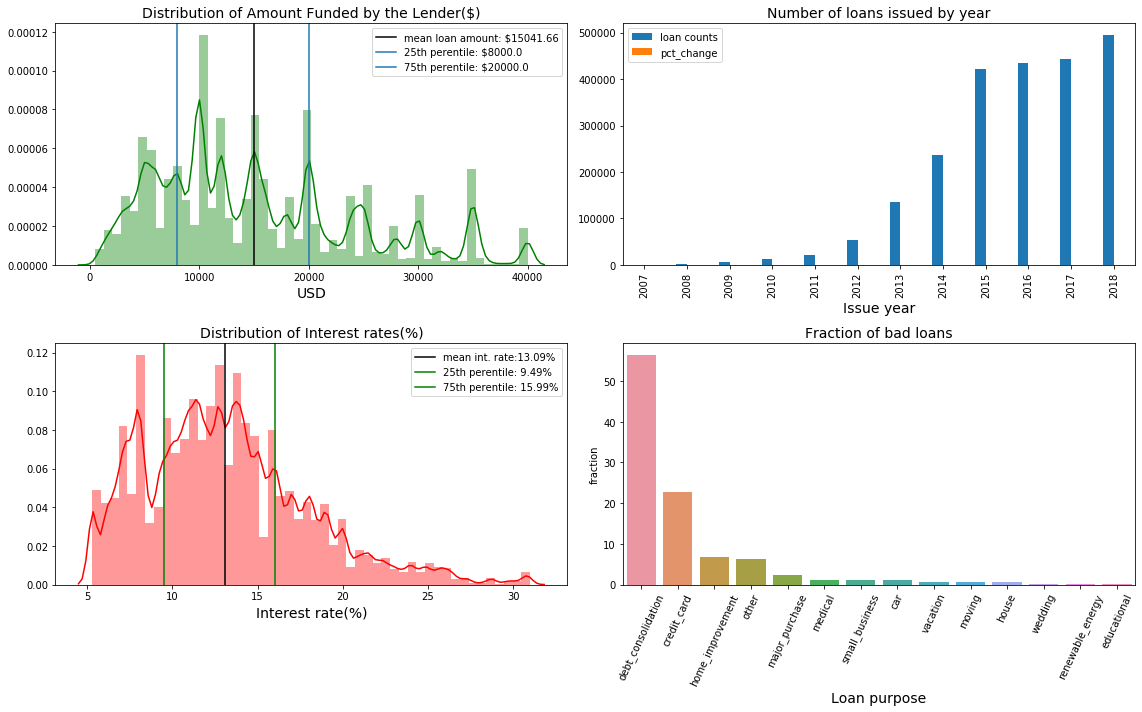

In [40]:
fig, ax = plt.subplots(2,2,figsize=(16,10),sharex=False, sharey=False)

funded_amount = df['funded_amount'].values
interest_rate = df['interest_rate'].values

sns.distplot(funded_amount, ax=ax[0,0], color="green")
ax[0,0].set_title("Distribution of Amount Funded by the Lender($)", fontsize=14)
ax[0,0].set_xlabel("USD",fontsize=14)
ax[0,0].axvline(funded_amount.mean(),color='k',
             label='mean loan amount: ${}'.format(round(funded_amount.mean(),2)))
ax[0,0].axvline(np.percentile(funded_amount,[25]),
              label = "25th perentile: ${}".format(np.percentile(funded_amount,[25])[0],2))
ax[0,0].axvline(np.percentile(funded_amount,[75]),
             label = "75th perentile: ${}".format(np.percentile(funded_amount,[75])[0],2))
ax[0,0].legend()

sns.distplot(interest_rate, ax=ax[1,0], color="red")
ax[1,0].set_title("Distribution of Interest rates(%)", fontsize=14,)
ax[1,0].set_xlabel("%",fontsize=14)
ax[1,0].axvline(interest_rate.mean(),color='k',
              label='mean int. rate:{}%'.format(round(interest_rate.mean(),2)))
ax[1,0].axvline(np.percentile(interest_rate,[25]),
              label = "25th perentile: {}%".format(np.percentile(interest_rate,[25])[0],2),
             color='green')
ax[1,0].axvline(np.percentile(interest_rate,[75]),
             label = "75th perentile: {}%".format(np.percentile(interest_rate,[75])[0],2),
             color='green')
ax[1,0].set_xlabel("Interest rate(%)",fontsize=14)
ax[1,0].legend()

sns.barplot(x='index',y='purpose',data=purpose_df,ax=ax[1,1])
ax[1,1].set_title('Fraction of bad loans', fontsize=14,)
ax[1,1].set_xlabel("Loan purpose",fontsize=14)

plt.xticks(rotation=65)
plt.ylabel('fraction')


by_year.plot(ax=ax[0,1],kind='bar')
ax[0,1].set_xlabel("Issue year",fontsize=14)
ax[0,1].set_title("Number of loans issued by year",fontsize=14)

plt.tight_layout()
plt.savefig('dashboard1.png')
plt.show()

# Percantage change in total number of loans by year

It can be seen below that the actual the number of loans (business volume) has been increasing drastically in the after days after incepltion however as the time passed on the rate of growth has decreased.

In [24]:
by_year['pct_change'] = by_year.pct_change()*100
by_year.columns = ['loan counts','pct_change']
by_year

,loan counts,pct_change
year_issued,,
2007,603,nan
2008,2393,296.8491
2009,5281,120.6853
2010,12537,137.3982
2011,21721,73.2552
2012,53367,145.6931
2013,134814,152.6168
2014,235629,74.7808
2015,421095,78.7110


# Is there a change in the fraction of bad loans?

The definition of bad loans is obviously somewhat arbitratry since "late loans" are included in the bad loan category. Grace Period loans are considered good loans in the following labeling.

As it can be seen from the graph the fraction of bad loans has been constantly decreasing since 2007(26.2%). In 2017 the fraction was 10.41%,
We can't take 2018 into account as the data for 2018 is not complete.

In [18]:
bad_loan = ["Charged Off", "Default", 
            "Does not meet the credit policy. Status:Charged Off",
            "Late (16-30 days)", 
            "Late (31-120 days)"]

df['loan_condition'] = np.nan

def loan_condition(status):
    if status in bad_loan:
        return 'Bad Loan'
    else:
        return 'Good Loan'


df['loan_condition'] = df['loan_status'].apply(loan_condition)

In [26]:
pd.DataFrame(df["loan_status"].value_counts(normalize=True)*100)


,loan_status
Fully Paid,46.0904
Current,40.6824
Charged Off,11.5742
Late (31-120 days),0.9686
In Grace Period,0.3960
Late (16-30 days),0.1653
Does not meet the credit policy. Status:Fully Paid,0.0879
Does not meet the credit policy. Status:Charged Off,0.0337
Default,0.0014


In [20]:
#Butchering a dataframe to get fraction of bad loans breakdown

good_bad = df.groupby(by=[df['year_issued'],'loan_condition']).count()[['loan_amount']]
good_bad.reset_index(inplace=True)
good_bad = good_bad.pivot_table(values='loan_amount',columns='loan_condition',index='year_issued')
good_bad['Bad loan propotion'] = good_bad['Bad Loan']/(good_bad['Bad Loan']+good_bad['Good Loan'])
good_bad.reset_index(inplace=True)

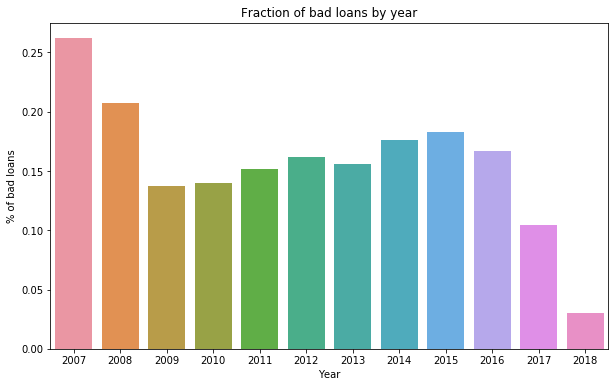

In [21]:
plt.figure(figsize=(10,6))
sns.barplot(x="year_issued", y="Bad loan propotion", data=good_bad)
plt.xlabel('Year')
plt.ylabel('% of bad loans')
plt.title('Fraction of bad loans by year')
plt.savefig('fraction_of_bad_loans.png')
plt.show()

# Are some regions better than other?

* At first the analysis was broken down by regions of the United States but the aggregated statistics didn't have much variation. So the breakown is done by state.

In [22]:
df['addr_state'].unique()

# Make a list with each of the regions by state.

west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']



df['region'] = np.nan

def finding_regions(state):
    if state in west:
        return 'West'
    elif state in south_west:
        return 'SouthWest'
    elif state in south_east:
        return 'SouthEast'
    elif state in mid_west:
        return 'MidWest'
    elif state in north_east:
        return 'NorthEast'
    
df['region'] = df['addr_state'].apply(finding_regions)

number_of_loans_by_region = df.groupby('region').count()[['loan_amount']]
average_int_rate_by_region = df.groupby('region').mean()['interest_rate']
average_annual_income_by_region = df.groupby('region').mean()['annual_income']
average_delinquency_by_region = df.groupby('region').mean()['delinq_amnt']
average_loan_amount_by_region = df.groupby('region').mean()['loan_amount']

by_region = pd.concat([number_of_loans_by_region,
          average_int_rate_by_region,
          average_annual_income_by_region,
           average_delinquency_by_region
          ],axis=1)
# change columns' names

by_region.columns = ['number of loans', 'mean interest rate',
                    'mean annual income','delinquency amount' ]

by_region.sort_values('number of loans',ascending=False)

,number of loans,mean interest rate,mean annual income,delinquency amount
region,,,,
SouthEast,550165,13.2107,75036.6062,10.8907
NorthEast,519095,13.1015,82149.9081,18.9065
West,515469,13.0267,80199.9910,10.3195
MidWest,403150,13.0557,72646.0699,9.0829
SouthWest,272789,13.0192,79772.0676,11.6450


In [904]:
number_of_loans_by_state = df.groupby('addr_state').count()[['loan_amount']]
average_int_rate_by_state = df.groupby('addr_state').mean()['interest_rate']
average_annual_income_by_state = df.groupby('addr_state').mean()['annual_income']
average_delinquency_by_state = df.groupby('addr_state').mean()['delinq_amnt']

by_state = pd.concat([number_of_loans_by_state,
           average_int_rate_by_state,
           average_annual_income_by_state,
           average_annual_income_by_state
          ],axis=1)
# change columns' names

by_state.columns = ['number of loans', 'mean interest rate',
                    'mean annual income','mean delinquency amount' ]

by_state.sort_values('number of loans',ascending=False)

,number of loans,mean interest rate,mean annual income,mean delinquency amount
addr_state,,,,
CA,314533,12.9766,83847.9811,83847.9811
NY,186389,13.2600,81057.0480,81057.0480
TX,186335,12.9994,82728.8140,82728.8140
FL,161991,13.1648,73171.6117,73171.6117
IL,91173,12.9601,79884.9221,79884.9221
NJ,83132,12.9901,89920.5098,89920.5098
PA,76939,13.1459,73940.3522,73940.3522
OH,75132,13.1373,69322.6124,69322.6124
GA,74196,13.2087,77857.5736,77857.5736


In [32]:
condition_by_state = df[['loan_condition','addr_state']]

In [33]:
condition_by_state = pd.crosstab(condition_by_state['addr_state'],condition_by_state['loan_condition'])

In [36]:
condition_by_state['bad_loan_ratio'] = condition_by_state['Bad Loan']/(condition_by_state['Bad Loan']+condition_by_state['Good Loan'])*100

In [37]:
condition_by_state.sort_values('bad_loan_ratio',ascending=False)

loan_condition,Bad Loan,Good Loan,bad_loan_ratio
addr_state,,,
IA,3,11,21.4286
AL,4198,23086,15.3863
AR,2581,14493,15.1166
MS,1891,10748,14.9616
OK,3088,17603,14.9244
LA,3839,21920,14.9035
NV,4690,27967,14.3614
NM,1686,10300,14.0664
NY,26080,160309,13.9922
